# Análisis de Ventas por Sucursal - Rent4you

Este notebook analiza las ventas (alquileres) por sucursal para identificar los puntos de venta más rentables.

## Objetivos:
- Analizar ingresos por sucursal
- Identificar patrones de demanda
- Evaluar eficiencia operacional
- Generar insights para toma de decisiones

In [26]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo
plt.style.use('default')
sns.set_palette('husl')

print('Librerías importadas exitosamente')

Librerías importadas exitosamente


In [27]:
# Cargar datasets
print('Cargando datasets...')

# Cargar dimensiones
dim_tiempo = pd.read_csv('../data/processed/dim_tiempo.csv')
dim_sucursal = pd.read_csv('../data/processed/dim_sucursal.csv')
dim_vehiculo = pd.read_csv('../data/processed/dim_vehiculo.csv')
dim_cliente = pd.read_csv('../data/processed/dim_cliente.csv')
dim_empleado = pd.read_csv('../data/processed/dim_empleado.csv')

# Cargar hechos
fact_alquileres = pd.read_csv('../data/processed/fact_alquileres.csv')
fact_gastos = pd.read_csv('../data/processed/fact_gastos.csv')

# Convertir fechas
dim_tiempo['fecha'] = pd.to_datetime(dim_tiempo['fecha'])

print('Datasets cargados exitosamente')
print(f'Alquileres: {len(fact_alquileres):,} registros')
print(f'Gastos: {len(fact_gastos):,} registros')
print(f'Sucursales: {len(dim_sucursal)} sucursales')

Cargando datasets...
Datasets cargados exitosamente
Alquileres: 10,000 registros
Gastos: 5,000 registros
Sucursales: 8 sucursales


In [28]:
# Crear dataset integrado para análisis
print('Creando dataset integrado...')

# Unir alquileres con dimensiones (usando suffixes para evitar conflictos)
ventas_completo = fact_alquileres.merge(dim_tiempo, on='fecha_id', how='left', suffixes=('', '_tiempo'))
ventas_completo = ventas_completo.merge(dim_sucursal, on='sucursal_id', how='left', suffixes=('', '_sucursal'))
ventas_completo = ventas_completo.merge(dim_vehiculo, on='vehiculo_id', how='left', suffixes=('', '_vehiculo'))
ventas_completo = ventas_completo.merge(dim_cliente, on='cliente_id', how='left', suffixes=('', '_cliente'))
ventas_completo = ventas_completo.merge(dim_empleado, on='empleado_id', how='left', suffixes=('', '_empleado'))

# Calcular métricas derivadas
ventas_completo['ingresos_netos'] = ventas_completo['precio_total'] - ventas_completo['descuento']
ventas_completo['precio_por_dia'] = ventas_completo['ingresos_netos'] / ventas_completo['dias_alquiler']

print(f'Dataset integrado creado: {len(ventas_completo):,} registros')
print('Columnas disponibles:', list(ventas_completo.columns))

Creando dataset integrado...
Dataset integrado creado: 10,000 registros
Columnas disponibles: ['alquiler_id', 'fecha_id', 'sucursal_id', 'vehiculo_id', 'cliente_id', 'empleado_id', 'dias_alquiler', 'precio_total', 'descuento', 'seguro_contratado', 'fecha', 'año', 'mes', 'trimestre', 'dia_semana', 'es_fin_semana', 'temporada', 'nombre_sucursal', 'ciudad', 'region', 'tipo_sucursal', 'fecha_apertura', 'tipo_vehiculo', 'marca', 'modelo', 'año_vehiculo', 'categoria_precio', 'estado', 'edad', 'genero', 'tipo_cliente', 'ciudad_residencia', 'segmento_riesgo', 'nombre', 'cargo', 'sucursal_id_empleado', 'fecha_contratacion', 'experiencia_años', 'ingresos_netos', 'precio_por_dia']


## 1. Análisis de Ingresos por Sucursal

In [29]:
# Análisis de ingresos por sucursal
ingresos_sucursal = ventas_completo.groupby(['sucursal_id', 'nombre_sucursal', 'ciudad', 'region']).agg({
    'ingresos_netos': ['sum', 'mean', 'count'],
    'dias_alquiler': 'sum',
    'precio_por_dia': 'mean'
}).round(2)

# Aplanar columnas
ingresos_sucursal.columns = ['ingresos_totales', 'ingreso_promedio', 'num_alquileres', 'dias_totales', 'precio_promedio_dia']
ingresos_sucursal = ingresos_sucursal.reset_index()

# Calcular métricas adicionales
ingresos_sucursal['ingresos_por_dia_operacion'] = ingresos_sucursal['ingresos_totales'] / 1095  # 3 años
ingresos_sucursal['utilizacion_promedio'] = ingresos_sucursal['dias_totales'] / (1095 * 30)  # Asumiendo 30 vehículos promedio

# Ordenar por ingresos totales
ingresos_sucursal = ingresos_sucursal.sort_values('ingresos_totales', ascending=False)

print('=== RANKING DE SUCURSALES POR INGRESOS ===')
for idx, (i, row) in enumerate(ingresos_sucursal.iterrows()):
    print(f"{idx+1}. {row['nombre_sucursal']} ({row['ciudad']}):")
    print(f"   Ingresos Totales: €{row['ingresos_totales']:,.2f}")
    print(f"   Número de Alquileres: {row['num_alquileres']:,}")
    print(f"   Ingreso Promedio: €{row['ingreso_promedio']:.2f}")
    print()

=== RANKING DE SUCURSALES POR INGRESOS ===
1. Rent4you Palma Aeropuerto (Palma):
   Ingresos Totales: €470,851.91
   Número de Alquileres: 1,330
   Ingreso Promedio: €354.02

2. Rent4you Barcelona Port (Barcelona):
   Ingresos Totales: €443,368.00
   Número de Alquileres: 1,280
   Ingreso Promedio: €346.38

3. Rent4you Zaragoza Centro (Zaragoza):
   Ingresos Totales: €435,534.84
   Número de Alquileres: 1,267
   Ingreso Promedio: €343.75

4. Rent4you Sevilla Centro (Sevilla):
   Ingresos Totales: €434,081.40
   Número de Alquileres: 1,267
   Ingreso Promedio: €342.61

5. Rent4you Madrid Centro (Madrid):
   Ingresos Totales: €433,134.16
   Número de Alquileres: 1,258
   Ingreso Promedio: €344.30

6. Rent4you Bilbao Industrial (Bilbao):
   Ingresos Totales: €432,416.22
   Número de Alquileres: 1,200
   Ingreso Promedio: €360.35

7. Rent4you Valencia Aeropuerto (Valencia):
   Ingresos Totales: €421,222.80
   Número de Alquileres: 1,219
   Ingreso Promedio: €345.55

8. Rent4you Málaga Cost

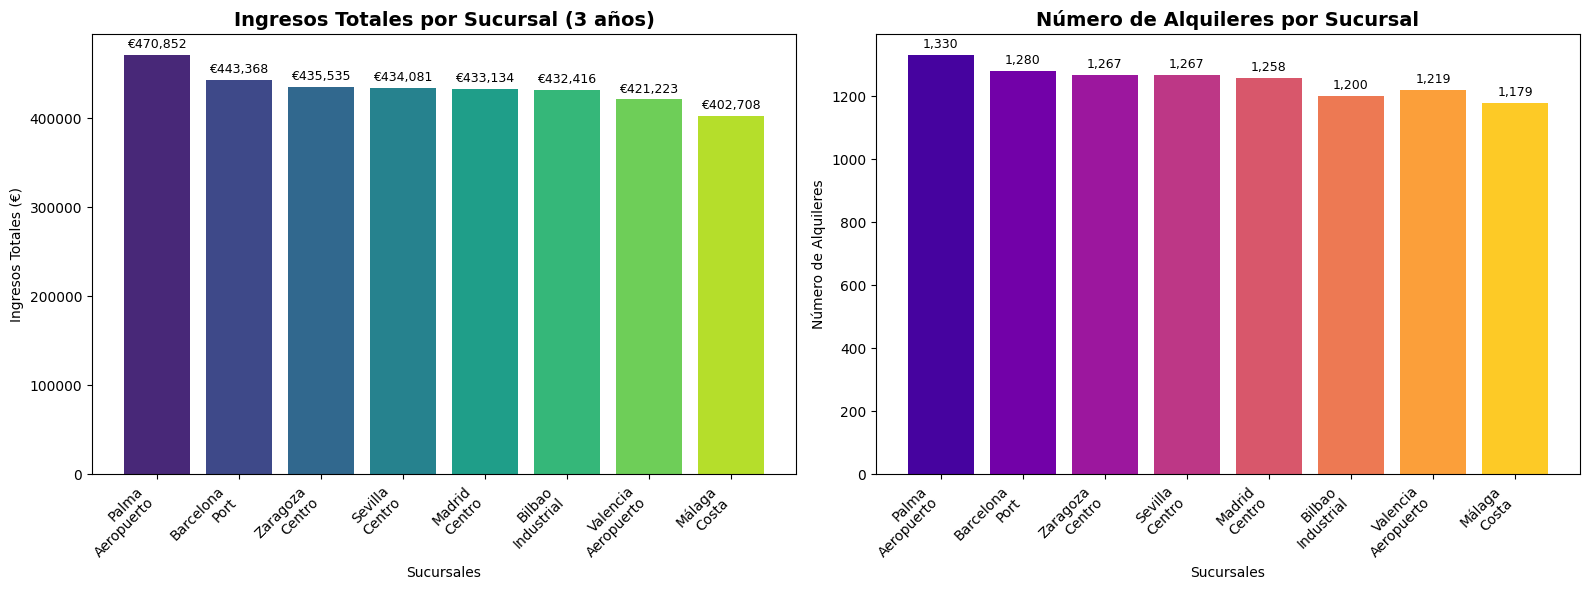

In [30]:
# Visualización 1: Ingresos totales por sucursal
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico de barras - Ingresos totales
bars1 = ax1.bar(range(len(ingresos_sucursal)), ingresos_sucursal['ingresos_totales'], 
                color=sns.color_palette('viridis', len(ingresos_sucursal)))
ax1.set_title('Ingresos Totales por Sucursal (3 años)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Sucursales')
ax1.set_ylabel('Ingresos Totales (€)')
ax1.set_xticks(range(len(ingresos_sucursal)))
ax1.set_xticklabels([f"{row['ciudad']}\n{row['nombre_sucursal'].split()[-1]}" 
                    for _, row in ingresos_sucursal.iterrows()], rotation=45, ha='right')

# Añadir valores en las barras
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'€{height:,.0f}', ha='center', va='bottom', fontsize=9)

# Gráfico de barras - Número de alquileres
bars2 = ax2.bar(range(len(ingresos_sucursal)), ingresos_sucursal['num_alquileres'],
                color=sns.color_palette('plasma', len(ingresos_sucursal)))
ax2.set_title('Número de Alquileres por Sucursal', fontsize=14, fontweight='bold')
ax2.set_xlabel('Sucursales')
ax2.set_ylabel('Número de Alquileres')
ax2.set_xticks(range(len(ingresos_sucursal)))
ax2.set_xticklabels([f"{row['ciudad']}\n{row['nombre_sucursal'].split()[-1]}" 
                    for _, row in ingresos_sucursal.iterrows()], rotation=45, ha='right')

# Añadir valores en las barras
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{height:,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 2. Análisis por Tipo de Vehículo y Sucursal

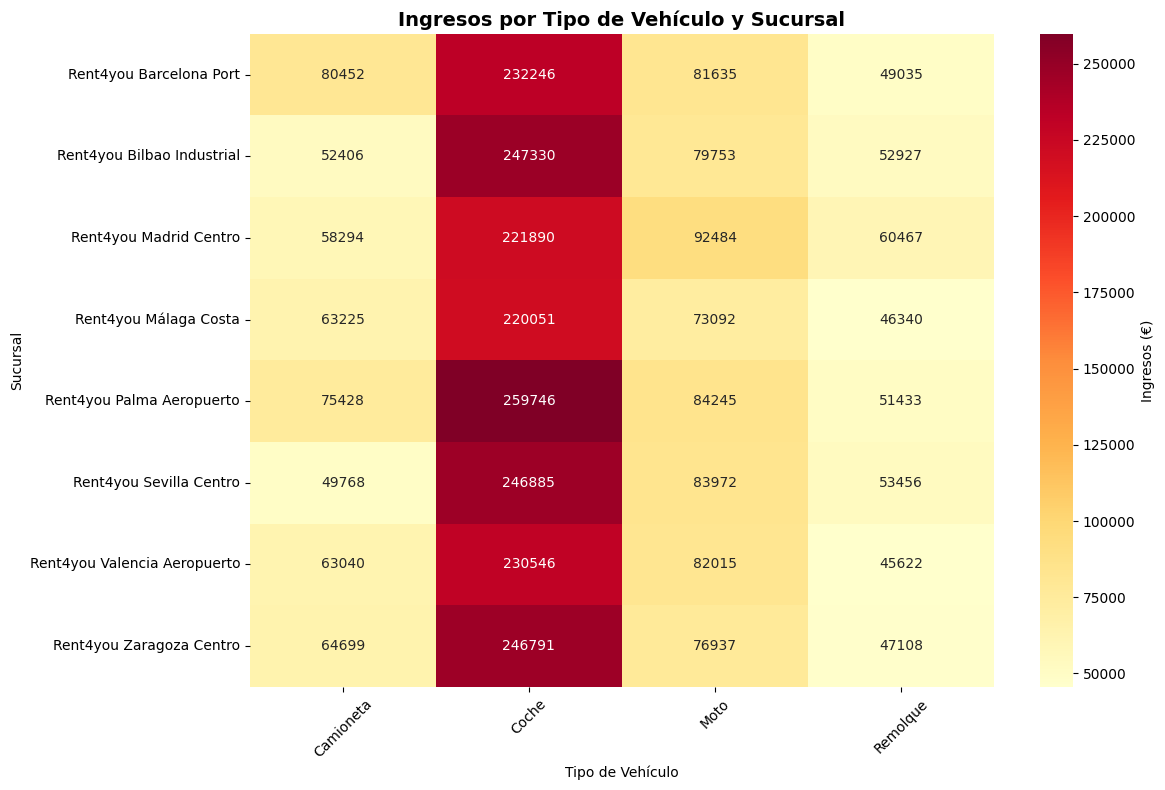

=== ESPECIALIZACIÓN POR SUCURSAL ===
Rent4you Barcelona Port: Coche (€232,246)
Rent4you Bilbao Industrial: Coche (€247,330)
Rent4you Madrid Centro: Coche (€221,890)
Rent4you Málaga Costa: Coche (€220,051)
Rent4you Palma Aeropuerto: Coche (€259,746)
Rent4you Sevilla Centro: Coche (€246,885)
Rent4you Valencia Aeropuerto: Coche (€230,546)
Rent4you Zaragoza Centro: Coche (€246,791)


In [31]:
# Análisis por tipo de vehículo
vehiculos_sucursal = ventas_completo.groupby(['nombre_sucursal', 'tipo_vehiculo']).agg({
    'ingresos_netos': 'sum',
    'alquiler_id': 'count'
}).reset_index()

# Crear tabla pivot
pivot_vehiculos = vehiculos_sucursal.pivot(index='nombre_sucursal', 
                                          columns='tipo_vehiculo', 
                                          values='ingresos_netos').fillna(0)

# Visualización con heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_vehiculos, annot=True, fmt='.0f', cmap='YlOrRd', 
            cbar_kws={'label': 'Ingresos (€)'})
plt.title('Ingresos por Tipo de Vehículo y Sucursal', fontsize=14, fontweight='bold')
plt.xlabel('Tipo de Vehículo')
plt.ylabel('Sucursal')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print('=== ESPECIALIZACIÓN POR SUCURSAL ===')
for sucursal in pivot_vehiculos.index:
    mejor_vehiculo = pivot_vehiculos.loc[sucursal].idxmax()
    mejor_ingreso = pivot_vehiculos.loc[sucursal].max()
    print(f"{sucursal}: {mejor_vehiculo} (€{mejor_ingreso:,.0f})")

## 3. Análisis de Eficiencia Operacional

In [32]:
# Calcular eficiencia por sucursal
eficiencia_sucursal = ventas_completo.groupby(['sucursal_id', 'nombre_sucursal', 'ciudad']).agg({
    'ingresos_netos': 'sum',
    'dias_alquiler': 'sum',
    'alquiler_id': 'count',
    'empleado_id': 'nunique'
}).reset_index()

eficiencia_sucursal.columns = ['sucursal_id', 'nombre_sucursal', 'ciudad', 
                               'ingresos_totales', 'dias_totales', 'num_alquileres', 'num_empleados']

# Calcular métricas de eficiencia
eficiencia_sucursal['ingresos_por_empleado'] = eficiencia_sucursal['ingresos_totales'] / eficiencia_sucursal['num_empleados']
eficiencia_sucursal['alquileres_por_empleado'] = eficiencia_sucursal['num_alquileres'] / eficiencia_sucursal['num_empleados']
eficiencia_sucursal['ingreso_por_dia_alquiler'] = eficiencia_sucursal['ingresos_totales'] / eficiencia_sucursal['dias_totales']

# Ordenar por eficiencia
eficiencia_sucursal = eficiencia_sucursal.sort_values('ingresos_por_empleado', ascending=False)

print('=== RANKING DE EFICIENCIA POR EMPLEADO ===')
for idx, (i, row) in enumerate(eficiencia_sucursal.iterrows()):
    print(f"{idx+1}. {row['nombre_sucursal']} ({row['ciudad']}):")
    print(f"   Ingresos por Empleado: €{row['ingresos_por_empleado']:,.2f}")
    print(f"   Alquileres por Empleado: {row['alquileres_por_empleado']:.1f}")
    print(f"   Número de Empleados: {row['num_empleados']}")
    print()

=== RANKING DE EFICIENCIA POR EMPLEADO ===
1. Rent4you Palma Aeropuerto (Palma):
   Ingresos por Empleado: €4,708.52
   Alquileres por Empleado: 13.3
   Número de Empleados: 100

2. Rent4you Barcelona Port (Barcelona):
   Ingresos por Empleado: €4,433.68
   Alquileres por Empleado: 12.8
   Número de Empleados: 100

3. Rent4you Zaragoza Centro (Zaragoza):
   Ingresos por Empleado: €4,355.35
   Alquileres por Empleado: 12.7
   Número de Empleados: 100

4. Rent4you Sevilla Centro (Sevilla):
   Ingresos por Empleado: €4,340.81
   Alquileres por Empleado: 12.7
   Número de Empleados: 100

5. Rent4you Madrid Centro (Madrid):
   Ingresos por Empleado: €4,331.34
   Alquileres por Empleado: 12.6
   Número de Empleados: 100

6. Rent4you Bilbao Industrial (Bilbao):
   Ingresos por Empleado: €4,324.16
   Alquileres por Empleado: 12.0
   Número de Empleados: 100

7. Rent4you Valencia Aeropuerto (Valencia):
   Ingresos por Empleado: €4,212.23
   Alquileres por Empleado: 12.2
   Número de Empleados: 

## 4. Análisis de Rentabilidad (Ingresos vs Gastos)

In [33]:
# Análisis de gastos por sucursal
gastos_sucursal = fact_gastos.groupby('sucursal_id').agg({
    'monto': 'sum'
}).reset_index()
gastos_sucursal.columns = ['sucursal_id', 'gastos_totales']

# Combinar ingresos y gastos
rentabilidad = ingresos_sucursal[['sucursal_id', 'nombre_sucursal', 'ciudad', 'ingresos_totales']].merge(
    gastos_sucursal, on='sucursal_id', how='left'
)

# Rellenar gastos faltantes con 0
rentabilidad['gastos_totales'] = rentabilidad['gastos_totales'].fillna(0)

# Calcular beneficio
rentabilidad['beneficio'] = rentabilidad['ingresos_totales'] - rentabilidad['gastos_totales']
rentabilidad['margen_beneficio'] = (rentabilidad['beneficio'] / rentabilidad['ingresos_totales']) * 100
# Evitar división por cero en ROI
rentabilidad['roi'] = np.where(rentabilidad['gastos_totales'] > 0, 
                               (rentabilidad['beneficio'] / rentabilidad['gastos_totales']) * 100, 
                               np.inf)

# Ordenar por beneficio
rentabilidad = rentabilidad.sort_values('beneficio', ascending=False)

print('=== ANÁLISIS DE RENTABILIDAD POR SUCURSAL ===')
for idx, (i, row) in enumerate(rentabilidad.iterrows()):
    print(f"{idx+1}. {row['nombre_sucursal']} ({row['ciudad']}):")
    print(f"   Ingresos: €{row['ingresos_totales']:,.2f}")
    print(f"   Gastos: €{row['gastos_totales']:,.2f}")
    print(f"   Beneficio: €{row['beneficio']:,.2f}")
    print(f"   Margen: {row['margen_beneficio']:.1f}%")
    roi_text = f"{row['roi']:.1f}%" if row['roi'] != np.inf else "∞%"
    print(f"   ROI: {roi_text}")
    print()

=== ANÁLISIS DE RENTABILIDAD POR SUCURSAL ===
1. Rent4you Madrid Centro (Madrid):
   Ingresos: €433,134.16
   Gastos: €597,427.67
   Beneficio: €-164,293.51
   Margen: -37.9%
   ROI: -27.5%

2. Rent4you Palma Aeropuerto (Palma):
   Ingresos: €470,851.91
   Gastos: €676,103.90
   Beneficio: €-205,251.99
   Margen: -43.6%
   ROI: -30.4%

3. Rent4you Barcelona Port (Barcelona):
   Ingresos: €443,368.00
   Gastos: €668,232.00
   Beneficio: €-224,864.00
   Margen: -50.7%
   ROI: -33.7%

4. Rent4you Zaragoza Centro (Zaragoza):
   Ingresos: €435,534.84
   Gastos: €665,302.43
   Beneficio: €-229,767.59
   Margen: -52.8%
   ROI: -34.5%

5. Rent4you Málaga Costa (Málaga):
   Ingresos: €402,708.27
   Gastos: €643,762.11
   Beneficio: €-241,053.84
   Margen: -59.9%
   ROI: -37.4%

6. Rent4you Sevilla Centro (Sevilla):
   Ingresos: €434,081.40
   Gastos: €697,810.87
   Beneficio: €-263,729.47
   Margen: -60.8%
   ROI: -37.8%

7. Rent4you Valencia Aeropuerto (Valencia):
   Ingresos: €421,222.80
   G